In [1]:

# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

# Configuración de estilos
sns.set(style='whitegrid')
%matplotlib inline

In [2]:
# Cargar los datos
orders = pd.read_csv('../data/orders.csv')
order_products_prior = pd.read_csv('../data/order_products__prior.csv')
products = pd.read_csv('../data/products.csv')
aisles = pd.read_csv('../data/aisles.csv')
departments = pd.read_csv('../data/departments.csv')

In [3]:
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [4]:
# Calcular fecha de la última compra en el dataset
max_order_number = orders['order_number'].max()

# Recency: Días desde el último pedido de cada usuario
user_last_order = orders.groupby('user_id')['days_since_prior_order'].sum().reset_index()
user_last_order.columns = ['user_id', 'recency']

# Frequency: Número de pedidos por usuario
user_freq = orders.groupby('user_id')['order_number'].max().reset_index()
user_freq.columns = ['user_id', 'frequency']

# Monetary: Número total de productos comprados por usuario (puede ser aproximación de "valor")
user_monetary = order_products_prior.merge(orders[['order_id', 'user_id']], on='order_id')
user_monetary = user_monetary.groupby('user_id').size().reset_index(name='monetary')

# Unión de las métricas
rfm = user_last_order.merge(user_freq, on='user_id').merge(user_monetary, on='user_id')
rfm

,user_id,recency,frequency,monetary
0,1,190.0,11,59
1,2,228.0,15,195
2,3,144.0,13,88
3,4,85.0,6,18
4,5,46.0,5,37
...,...,...,...,...
206204,206205,50.0,4,32
206205,206206,249.0,68,285
206206,206207,229.0,17,223
206207,206208,361.0,50,677


In [5]:

# 1. Semilla fija para que los datos sean estables
np.random.seed(42)

# 2. Lista de usuarios sobre los que simulamos los datos
user_ids = rfm['user_id']
n_users = len(user_ids)

# 3. Generación de datos demográficos simulados
user_info = pd.DataFrame({
    'user_id': user_ids,
    'edad': np.random.randint(18, 70, size=n_users),
    'renta_mensual': np.random.normal(loc=2000, scale=600, size=n_users).astype(int),
    'sexo': np.random.choice(['hombre', 'mujer'], size=n_users),
    'estado_civil': np.random.choice(['soltero/a', 'casado/a', 'divorciado/a', 'viudo/a'], size=n_users, p=[0.5, 0.35, 0.1, 0.05]),
    'tamaño_hogar': np.random.choice([1, 2, 3, 4, 5], size=n_users, p=[0.2, 0.3, 0.25, 0.15, 0.1]),
    'zona_residencial': np.random.choice(['urbana', 'suburbana', 'rural'], size=n_users, p=[0.5, 0.3, 0.2])
})

# 4. Guardamos los datos simulados en disco (puedes usar .csv o .parquet)
user_info.to_csv("datos_demograficos_simulados.csv", index=False)


In [6]:
rfm_enriquecido = rfm.merge(user_info, on='user_id')
rfm_enriquecido

,user_id,recency,frequency,monetary,edad,renta_mensual,sexo,estado_civil,tamaño_hogar,zona_residencial
0,1,190.0,11,59,56,2653,mujer,soltero/a,3,urbana
1,2,228.0,15,195,69,2484,hombre,soltero/a,2,suburbana
2,3,144.0,13,88,46,1251,mujer,casado/a,3,rural
3,4,85.0,6,18,32,1631,hombre,soltero/a,3,suburbana
4,5,46.0,5,37,60,1825,mujer,divorciado/a,3,urbana
...,...,...,...,...,...,...,...,...,...,...
206204,206205,50.0,4,32,44,2689,hombre,casado/a,4,urbana
206205,206206,249.0,68,285,54,1876,hombre,soltero/a,3,suburbana
206206,206207,229.0,17,223,42,1442,mujer,divorciado/a,2,suburbana
206207,206208,361.0,50,677,23,1591,mujer,soltero/a,2,urbana


In [7]:
#One-Hot Encoding a las variables categóricas
encoder = OneHotEncoder(drop='first',  sparse_output=False)
categorical_cols = ["sexo", "estado_civil", "zona_residencial"]
encoded_data = encoder.fit_transform(rfm_enriquecido[categorical_cols])
encoded_data

array([[1., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 1., 0., 0., 1., 0.],
       [1., 0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 0., 1.]])

In [8]:
#Crear DataFrame con columnas codificadas
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols), index=rfm_enriquecido.index)
encoded_df

,sexo_mujer,estado_civil_divorciado/a,estado_civil_soltero/a,estado_civil_viudo/a,zona_residencial_suburbana,zona_residencial_urbana
0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
206204,0.0,0.0,0.0,0.0,0.0,1.0
206205,0.0,0.0,1.0,0.0,1.0,0.0
206206,1.0,1.0,0.0,0.0,1.0,0.0
206207,1.0,0.0,1.0,0.0,0.0,1.0


In [9]:
numerical_cols = ["recency", "frequency", "monetary", "edad", "renta_mensual", "tamaño_hogar"]
numerical_df = rfm_enriquecido[numerical_cols]
numerical_df


,recency,frequency,monetary,edad,renta_mensual,tamaño_hogar
0,190.0,11,59,56,2653,3
1,228.0,15,195,69,2484,2
2,144.0,13,88,46,1251,3
3,85.0,6,18,32,1631,3
4,46.0,5,37,60,1825,3
...,...,...,...,...,...,...
206204,50.0,4,32,44,2689,4
206205,249.0,68,285,54,1876,3
206206,229.0,17,223,42,1442,2
206207,361.0,50,677,23,1591,2


In [10]:
final_df = pd.concat([numerical_df, encoded_df], axis=1)
final_df

,recency,frequency,monetary,edad,renta_mensual,tamaño_hogar,sexo_mujer,estado_civil_divorciado/a,estado_civil_soltero/a,estado_civil_viudo/a,zona_residencial_suburbana,zona_residencial_urbana
0,190.0,11,59,56,2653,3,1.0,0.0,1.0,0.0,0.0,1.0
1,228.0,15,195,69,2484,2,0.0,0.0,1.0,0.0,1.0,0.0
2,144.0,13,88,46,1251,3,1.0,0.0,0.0,0.0,0.0,0.0
3,85.0,6,18,32,1631,3,0.0,0.0,1.0,0.0,1.0,0.0
4,46.0,5,37,60,1825,3,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
206204,50.0,4,32,44,2689,4,0.0,0.0,0.0,0.0,0.0,1.0
206205,249.0,68,285,54,1876,3,0.0,0.0,1.0,0.0,1.0,0.0
206206,229.0,17,223,42,1442,2,1.0,1.0,0.0,0.0,1.0,0.0
206207,361.0,50,677,23,1591,2,1.0,0.0,1.0,0.0,0.0,1.0


In [11]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206209 entries, 0 to 206208
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   recency                     206209 non-null  float64
 1   frequency                   206209 non-null  int64  
 2   monetary                    206209 non-null  int64  
 3   edad                        206209 non-null  int32  
 4   renta_mensual               206209 non-null  int32  
 5   tamaño_hogar                206209 non-null  int32  
 6   sexo_mujer                  206209 non-null  float64
 7   estado_civil_divorciado/a   206209 non-null  float64
 8   estado_civil_soltero/a      206209 non-null  float64
 9   estado_civil_viudo/a        206209 non-null  float64
 10  zona_residencial_suburbana  206209 non-null  float64
 11  zona_residencial_urbana     206209 non-null  float64
dtypes: float64(7), int32(3), int64(2)
memory usage: 16.5 MB


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_df)


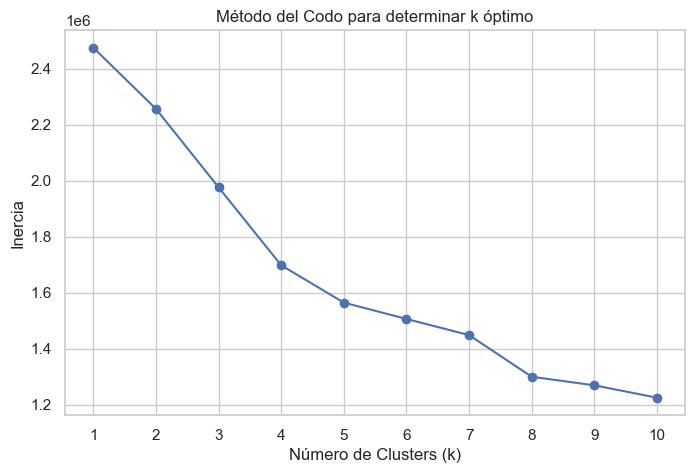

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#Probar diferentes valores de k
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar k óptimo')
plt.xticks(k_range)
plt.grid(True)
plt.show()


In [14]:
# Probar con diferentes valores de k
for k in [4, 5, 7]:
    print(f"\n--- Clustering con k = {k} ---")
    kmeans = KMeans(n_clusters=k, random_state=42)
    rfm_enriquecido[f'cluster_k{k}'] = kmeans.fit_predict(scaled_data)
    
    resumen = rfm_enriquecido.groupby(f'cluster_k{k}').mean(numeric_only=True)
    print(resumen)


--- Clustering con k = 4 ---
                  user_id     recency  frequency    monetary       edad  \
cluster_k4                                                                
0           102952.021828  168.684857  15.396024  139.550477  43.575814   
1           103313.684669  145.100790  10.933988   92.188548  43.536188   
2           103042.822185  144.312141  10.828493   91.031783  43.452641   
3           102763.322095  327.595317  47.509425  514.319309  43.280509   

            renta_mensual  tamaño_hogar  
cluster_k4                               
0             2004.173455      2.646365  
1             1997.730823      2.648559  
2             1997.918359      2.658333  
3             2003.762469      2.649015  

--- Clustering con k = 5 ---
                  user_id     recency  frequency    monetary       edad  \
cluster_k5                                                                
0           102954.763436  168.301446  15.219465  137.827438  43.564100   
1           